## Chapter 11. Model Evaluation 

### 11.0 Introduction 

In this chapter we will examine strategies for evaluating the quality of models created through our learning algorithms. It might appear strange to discuss model evaluation before discussing how to create them, but there is a method to our madness. Models are only as useful as the quality of their predictions, and thus fundamentally our goal is not to create models (which is easy) but to create high-quality models (which is hard). Therefore, before we explore the myriad learning algorithms, we first set up how we can evaluate the models they produce. 

### 11.1 Cross-Validating Models 

#### Problem

You want to evaluate how well your model will work in the real world. 

#### Solution 

Create a pipeline that preprocesses the data, trains the model, and then evaluates it using cross-validation


In [1]:
# Load libraries
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler



In [17]:
# Load digits dataset
digits = datasets.load_digits()

# Create features matrix
features = digits.data
print(features.shape)
# Create target vector
target = digits.target
print(target.shape)
# Create standardizer
standardizer = StandardScaler()

# Create logistic regression object
logit = LogisticRegression()


(1797, 64)
(1797,)


In [18]:
# Create a pipeline that standardizes, then runs logistic regression
pipeline = make_pipeline(standardizer, logit)

# Create k-Fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=1)

# Conduct k-fold cross-validation
cv_results = cross_val_score(pipeline, # Pipeline
                             features, # Feature matrix
                             target, # Target vector
                             cv=kf, # Cross-validation technique
                             scoring="accuracy", # Loss function
                             n_jobs=-1) # Use all CPU scores

# Calculate mean
cv_results.mean() 

0.9693916821849783

#### Discussion 

At first consideration, evaluating supervised-learning models might appear straightforward: train a model and then calculate how well it did using some performance metric (accuracy, squared errors, etc.). However, this approach is fundamentally flawed. If we train a model using our data, and then evaluate how well it did on that data, we are not achieving our desired goal. Our goal is not to evaluate how well the model does on our training data, but how well it does on data it has never seen before (e.g., a new customer, a new crime, a new image). For this reason, our method of evaluation should help us understand how well models are able to make predictions from data they have never seen before. 

One strategy might be to hold off a slice of data for testing. This is called validation (or hold-out). In validation our observations (features and targets) are split into two sets, traditionally called the training set and the test set. We take the test set and put it off to the side, pretending that we have never seen it before. Next we train our model using our training set, using the features and target vector to teach the model how to make the best prediction. Finally, we simulate having never before seen external data by evaluating how our model trained on our training set performs on our test set. However, the validation approach has two major weaknesses. First, the performance of the model can be highly dependent on which few observations were selected for the test set. Second, the model is not being trained using all the available data, and not being evaluated on all the available data. 

A better strategy, which overcomes these weaknesses, is called k-fold cross-validation (KFCV). In KFCV, we split the data into k parts called “folds.” The model is then trained using k – 1 folds — combined into one training set — and then the last fold is used as a test set. We repeat this k times, each time using a different fold as the test set. The performance on the model for each of the k iterations is then averaged to produce an overall measurement. 

In our solution, we conducted k-fold cross-validation using 10 folds and outputted the evaluation scores to cv_results: 

In [4]:
# View score for all 10 folds
cv_results 

array([0.97777778, 0.98888889, 0.96111111, 0.94444444, 0.97777778,
       0.98333333, 0.95555556, 0.98882682, 0.97765363, 0.93854749])

There are three important points to consider when we are using KFCV. 

First, KFCV assumes that each observation was created independent from the other (i.e., the data is **I**ndependent **I**dentically **D**istributed (**IID**). If the data is IID, it is a good idea to shuffle observations when assigning to folds. In scikit-learn we can set shuffle=True to perform shuffling. 

Second, when we are using KFCV to evaluate a classifier, it is often beneficial to have folds containing roughly the same percentage of observations from each of the different target classes (called stratified k-fold). For example, if our target vector contained gender and 80% of the observations were male, then each fold would contain 80% male and 20% female observations. In scikit-learn, we can conduct stratified k-fold cross-validation by replacing the KFold class with StratifiedKFold.

Finally, when we are using validation sets or cross-validation, it is important to preprocess data based on the training set and then apply those transformations to both the training and test set. For example, when we fit our standardization object, standardizer, we calculate the mean and variance of only the training set. Then we apply that transformation (using transform) to both the training and test sets: 


In [6]:
# Import library
from sklearn.model_selection import train_test_split

# Create training and test sets
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.1, random_state=1)

# Fit standardizer to training set
standardizer.fit(features_train)

# Apply to both training and test sets
features_train_std = standardizer.transform(features_train)
features_test_std = standardizer.transform(features_test) 

The reason for this is because we are pretending that the test set is unknown data. If we fit both our preprocessors using observations from both training and test sets, some of the information from the test set leaks into our training set. This rule applies for any preprocessing step such as feature selection. 

scikit-learn’s pipeline package makes this easy to do while using cross-validation techniques. We first create a pipeline that preprocesses the data (e.g., standardizer) and then trains a model (logistic regression, logit): 

In [7]:
# Create a pipeline
pipeline = make_pipeline(standardizer, logit)


 Then we run KFCV using that pipeline and scikit does all the work for us: 

In [8]:
# Do k-fold cross-validation
cv_results = cross_val_score(pipeline, # Pipeline
                             features, # Feature matrix
                             target, # Target vector
                             cv=kf, # Cross-validation technique
                             scoring="accuracy", # Loss function
                             n_jobs=-1) # Use all CPU scores 

cross_val_score comes with three parameters that we have not discussed that are worth noting. cv determines our cross-validation technique. K-fold is the most common by far, but there are others, like leave-one-out-cross-validation where the number of folds k equals the number of observations. The scoring parameter defines our metric for success, a number of which are discussed in other recipes in this chapter. Finally, n_jobs=-1 tells scikit-learn to use every core available. For example, if your computer has four cores (a common number for laptops), then scikit-learn will use all four cores at once to speed up the operation. 


#### See Also 

[Why every statistician should know about cross-validation](https://robjhyndman.com/hyndsight/crossvalidation/)

[Cross-Validation Gone Wrong](https://betatim.github.io/posts/cross-validation-gone-wrong/)



### 11.2 Creating a Baseline Regression Model 

#### Problem 

You want a simple baseline regression model to compare against your model. 

#### Solution 
Use scikit-learn’s DummyRegressor to create a simple model to use as a baseline: 


In [20]:
# Load libraries
from sklearn.datasets import load_boston
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split

# Load data
boston = load_boston()

# Create features
features, target = boston.data, boston.target

# Make test and training split
features_train, features_test, target_train, target_test = train_test_split(
    features, target, random_state=0)
# Create a dummy regressor
dummy = DummyRegressor(strategy='mean')

# "Train" dummy regressor
dummy.fit(features_train, target_train)

# Get R-squared score
dummy.score(features_test, target_test) -0.0011193592039553391 


-0.002238718407910678

To compare, we train our model and evaluate the performance score:

In [21]:
# Load library
from sklearn.linear_model import LinearRegression

# Train simple linear regression model
ols = LinearRegression()
ols.fit(features_train, target_train)

# Get R-squared score
ols.score(features_test, target_test)


0.6354638433202103

#### Discussion 

DummyRegressor allows us to create a very simple model that we can use as a baseline to compare against our actual model. This can often be useful to simulate a “naive” existing prediction process in a product or system. For example, a product might have been originally hardcoded to assume that all new users will spend $100 in the first month, regardless of their features. If we encode that assumption into a baseline model, we are able to concretely state the benefits of using a machine learning approach.

DummyRegressor uses the strategy parameter to set the method of making predictions, including the mean or median value in the training set. Furthermore, if we set strategy to constant and use the constant parameter, we can set the dummy regressor to predict some constant value for every observation: 

In [22]:
# Create dummy regressor that predicts 20's for everything
clf = DummyRegressor(strategy='constant', constant=20)
clf.fit(features_train, target_train)

# Evaluate score
clf.score(features_test, target_test) 

-0.06510502029325727

One small note regarding score. By default, score returns the coefficient of determination (R-squared,$R^2$) score:


\begin{equation*}
R^2 = 1 - \frac{\sum_{i} \left(y_i - \hat{y_i}\right)^2}{\sum_{i} \left(y_i - \bar{y_i}\right)^2}\
\end{equation*}


where $y_i$ is the true value of the target observation,  $\hat{y_i}$ is the predicted value, and $\bar{y_i}$ is the mean value for the target vector. The closer R2 is to 1, the more of the variance in the target vector that is explained by the features.

### 11.3 Creating a Baseline Classification Model 

#### Problem 

You want a simple baseline classifier to compare against your model.

#### Solution

Use scikit-learn’s DummyClassifier: # Load libraries

In [26]:
from sklearn.datasets import load_iris
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

# Load data
iris = load_iris()

# Create target vector and feature matrix
features, target = iris.data, iris.target
print(features.shape)
print(target.shape)

# Split into training and test set
features_train, features_test, target_train, target_test = train_test_split(
features, target, random_state=0)

# Create dummy classifier
dummy = DummyClassifier(strategy='uniform', random_state=1)

# "Train" model
dummy.fit(features_train, target_train)
# Get accuracy score
dummy.score(features_test, target_test)

(150, 4)
(150,)


0.42105263157894735

By comparing the baseline classifier to our trained classifier, we can see the improvement:

In [27]:
# Load library
from sklearn.ensemble import RandomForestClassifier

# Create classifier
classifier = RandomForestClassifier()

# Train model
classifier.fit(features_train, target_train)

# Get accuracy score
classifier.score(features_test, target_test) 

0.9736842105263158

#### Discussion 

A common measure of a classifier’s performance is how much better it is than random guessing. scikit-learn’s DummyClassifier makes this comparison easy. The strategy parameter gives us a number of options for generating values. There are two particularly useful strategies. First, **stratified** makes predictions that are proportional to the training set’s target vector’s class proportions (i.e., if 20% of the observations in the training data are women, then DummyClassifier will predict women 20% of the time). Second, **uniform** will generate predictions uniformly at random between the different classes. For example, if 20% of observations are women and 80% are men, **uniform** will produce predictions that are 50% women and 50% men. 

#### See Also 

[scikit-learn documentation: DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html)



### 11.4 Evaluating Binary Classifier Predictions 

#### Problem 

Given a trained classification model, you want to evaluate its quality. 

#### Solution

Use scikit-learn’s cross_val_score to conduct cross-validation while using the scoring parameter to define one of a number of performance metrics, including accuracy, precision, recall, and F1. Accuracy is a common performance metric. It is simply the proportion of observations predicted correctly:

\begin{equation*}
Accuracy = \frac{TP + TN}{TP+TN+FP+FN}\
\end{equation*}

where: 

- TP is the number of true positives. Observations that are part of the positive class (has the disease, purchased the product, etc.) and that we predicted correctly.  
- TN is the number of true negatives. Observations that are part of the negative class (does not have the disease, did not purchase the product, etc.) and that we predicted correctly.  
- FP is the number of false positives. Also called a Type I error. Observations predicted to be part of the positive class that are actually part of the negative class.  
- FN is the number of false negatives. Also called a Type II error. Observations predicted to be part of the negative class that are actually part of the positive class.  

We can measure accuracy in three-fold (the default number of folds) cross-validation by setting scoring="accuracy": 

In [28]:
# Load libraries
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import make_classification

# Generate features matrix and target vector
X, y = make_classification(n_samples = 10000,
                           n_features = 3,
                           n_informative = 3,
                           n_redundant = 0,
                           n_classes = 2,
                           random_state = 1)

# Create logistic regression
logit = LogisticRegression()

# Cross-validate model using accuracy
cross_val_score(logit, X, y, scoring="accuracy")


array([0.9555, 0.95  , 0.9585, 0.9555, 0.956 ])

The appeal of accuracy is that it has an intuitive and plain English explanation: proportion of observations predicted correctly. However, in the real world, often our data has imbalanced classes (e.g., the 99.9% of observations are of class 1 and only 0.1% are class 2). When in the presence of imbalanced classes, accuracy suffers from a paradox where a model is highly accurate but lacks predictive power. For example, imagine we are trying to predict the presence of a very rare cancer that occurs in 0.1% of the population. After training our model, we find the accuracy is at 95%. However, 99.9% of people do not have the cancer: if we simply created a model that “predicted” that nobody had that form of cancer, our naive model would be 4.9% more accurate, but clearly is not able to predict anything. For this reason, we are often motivated to use other metrics like **precision**, **recall**, and the **$F_1$** score. 

**Precision** is the proportion of every observation predicted to be positive that is actually positive. We can think about it as a measurement noise in our predictions — that is, when we predict something is positive, how likely we are to be right. Models with high precision are pessimistic in that they only predict an observation is of the positive class when they are very certain about it. Formally, precision is:

\begin{equation*}
Precision = \frac{TP}{TP+FP}\
\end{equation*}


In [29]:
# Cross-validate model using precision
cross_val_score(logit, X, y, scoring="precision")


array([0.95963673, 0.94820717, 0.9635996 , 0.96149949, 0.96060606])

**Recall** is the proportion of every positive observation that is truly positive. **Recall** measures the model’s ability to identify an observation of the positive class. Models with high recall are optimistic in that they have a low bar for predicting that an observation is in the positive class:

\begin{equation*}
Recall = \frac{TP}{TP+FN}\
\end{equation*}

In [30]:
# Cross-validate model using recall
cross_val_score(logit, X, y, scoring="recall")

array([0.951, 0.952, 0.953, 0.949, 0.951])

If this is the first time you have encountered precision and recall, it is understandable if it takes you a little while to fully understand them. This is one of the downsides to accuracy; precision and recall are less intuitive. Almost always we want some kind of balance between precision and recall, and this role is filled by the **$F_1$**  score. The **$F_1$**  score is the harmonic mean (a kind of average used for ratios): 

\begin{equation*}
F_1 = 2 *  \frac{Precision *  Recall}{Precision + Recall}\
\end{equation*}

It is a measure of correctness achieved in positive prediction — that is, of observations labeled as positive, how many are actually positive:


In [31]:
# Cross-validate model using recall
cross_val_score(logit, X, y, scoring="f1")

array([0.95529884, 0.9500998 , 0.95827049, 0.95520886, 0.95577889])

#### Discussion 

As an evaluation metric, accuracy has some valuable properties, especially its simple intuition. However, better metrics often involve using some balance of precision and **recall** — that is, a trade-off between the optimism and pessimism of our model.  **$F_1$** represents a balance between the **recall** and **precision**, where the relative contributions of both are equal. 

Alternatively to using cross_val_score, if we already have the true y values and the predicted y values, we can calculate metrics like **accuracy** and **recall** directly:

In [32]:
# Load library
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create training and test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.1,
                                                    random_state=1)
# Predict values for training target vector
y_hat = logit.fit(X_train, y_train).predict(X_test)

# Calculate accuracy
accuracy_score(y_test, y_hat)


0.947

#### See Also 

[Accuracy paradox](https://en.wikipedia.org/wiki/Accuracy_paradox)


### 11.5 Evaluating Binary Classifier Thresholds 

#### Problem 

You want to evaluate a binary classifier and various probability thresholds. 

#### Solution 

The Receiving Operating Characteristic (ROC) curve is a common method for evaluating the quality of a binary classifier. ROC compares the presence of true positives and false positives at every probability threshold (i.e., the probability at which an observation is predicted to be a class). By plotting the ROC curve, we can see how the model performs. A classifier that predicts every observation correctly would look like the solid light gray line in the following chart, going straight up to the top immediately. 

A classifier that predicts at random will appear as the diagonal line. The better the model, the closer it is to the solid line. In scikit-learn, we can use roc_curve to calculate the true and false positives at each threshold, then plot them:



In [34]:
# Load libraries
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

# Create feature matrix and target vector
features, target = make_classification(n_samples=10000,
                                       n_features=10,
                                       n_classes=2,
                                       n_informative=3,
                                       random_state=3)

# Split into training and test sets
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.1, random_state=1)

# Create classifier
logit = LogisticRegression()

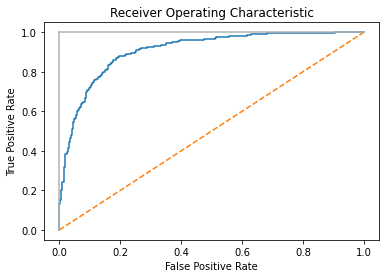

In [35]:
# Train model
logit.fit(features_train, target_train)

# Get predicted probabilities
target_probabilities = logit.predict_proba(features_test)[:,1]

# Create true and false positive rates
false_positive_rate, true_positive_rate, threshold = roc_curve(target_test,
                                                               target_probabilities)

# Plot ROC curve
plt.title("Receiver Operating Characteristic")
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()
